# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle

# Read Dataset

In [ ]:
# uplode csv file
from google.colab import files
uploaded = files.upload()

Saving exercise.csv to exercise.csv


In [ ]:
# read csv file
calories  = pd.read_csv('calories.csv')

In [ ]:
exercise = pd.read_csv('exercise.csv')

In [ ]:
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [ ]:
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
#	Make sure that user_id values are unique and that the set of user_id's is the same in the two datafiles.

unique_calories = calories['User_ID'].nunique()
unique_exercise = exercise['User_ID'].nunique()

print(f"Number of unique User_ID in calories df: {unique_calories}")
print(f"Number of unique User_ID in exercise df: {unique_exercise}")

Number of unique User_ID in calories df: 15000
Number of unique User_ID in exercise df: 15000


In [ ]:
# Check if both datasets contain the same set of user_ids
user_ids_match = set(calories['User_ID']) == set(exercise['User_ID'])

unique_calories, unique_exercise, user_ids_match

(15000, 15000, True)

In [ ]:
final_data = pd.merge(calories, exercise, on = 'User_ID')

In [ ]:
final_data.head()

,User_ID,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,35.0,female,27,154.0,58.0,10.0,81.0,39.8


# Dataset Overview

##  Dataset Basic Information

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


##  Summary Statistics for Numerical Variables

In [ ]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
User_ID,15000.0,1.497736e+07,2.872851e+06,10001159.0,12474190.75,14997285.0,17449278.75,19999647.0
Calories,15000.0,8.953953e+01,6.245698e+01,1.0,35.00,79.0,138.00,314.0
Age,15000.0,4.278980e+01,1.698026e+01,20.0,28.00,39.0,56.00,79.0
Height,15000.0,1.744651e+02,1.425811e+01,123.0,164.00,175.0,185.00,222.0
Weight,15000.0,7.496687e+01,1.503566e+01,36.0,63.00,74.0,87.00,132.0
Duration,15000.0,1.553060e+01,8.319203e+00,1.0,8.00,16.0,23.00,30.0
Heart_Rate,15000.0,9.551853e+01,9.583328e+00,67.0,88.00,96.0,103.00,128.0
Body_Temp,15000.0,4.002545e+01,7.792299e-01,37.1,39.60,40.2,40.60,41.5


In [ ]:
final_data.drop('User_ID', axis=1, inplace=True)

## Summary Statistics for Categorical Variables

In [ ]:
final_data.describe(include='object').T

,count,unique,top,freq
Gender,15000,2,female,7553


In [ ]:
def grab_col_names(df):
    # Separate columns into categorical and numerical
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    print(f'cat_col: {len(categorical_cols)}')
    print(f'num_col: {len(numerical_cols)}')

    return categorical_cols, numerical_cols

In [ ]:
def identify_check(dataframe):
    print('-' * 80)
    print(f'Categorical : {categorical_cols}')
    print('-' * 80)
    print(f'Numerical : {numerical_cols}')


categorical_cols, numerical_cols = grab_col_names(final_data)
identify_check(final_data)

cat_col: 1
num_col: 7
--------------------------------------------------------------------------------
Categorical : Index(['Gender'], dtype='object')
--------------------------------------------------------------------------------
Numerical : Index(['Calories', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp'],
      dtype='object')


In [ ]:
# find unqie value and number of uniqe values in categorical culomns
for col in categorical_cols:
  print(col,':',final_data[col].nunique())
  print(col,':',final_data[col].unique())
  print('-'*50)


Gender : 2
Gender : ['male' 'female']
--------------------------------------------------


# Data Cleaning

In [ ]:
# Percentage of missing values sorted in descending order.
final_data.isnull().mean().sort_values(ascending=False)*100

,0
Calories,0.0
Gender,0.0
Age,0.0
Height,0.0
Weight,0.0
Duration,0.0
Heart_Rate,0.0
Body_Temp,0.0


# EDA

For our **Exploratory Data Analysis** (EDA), we'll take it in two main steps:

1. **Univariate Analysis**: Here, we'll focus on one feature at a time to understand its distribution and range.

2. **Bivariate Analysis**: In this step, we'll explore the relationship between each feature and the target variable. This helps us figure out the importance and influence of each feature on the target outcome.

With these two steps, we aim to gain insights into the individual characteristics of the data and also how each feature relates to our main goal: **predicting the target variable**.

## Univariate Analysis

We undertake univariate analysis on the dataset's features, based on their datatype:

  - For **numerical data**: We employ histograms to gain insight into the distribution of each feature. This allows us to understand the central tendency, spread, and shape of the dataset's distribution.
  - For **categorical data**: Bar plots are utilized to visualize the frequency of each category. This provides a clear representation of the prominence of each category within the respective feature.
By employing these visualization techniques, we're better positioned to understand the individual characteristics of each feature in the dataset.

### Numerical Variables Univariate Analysis

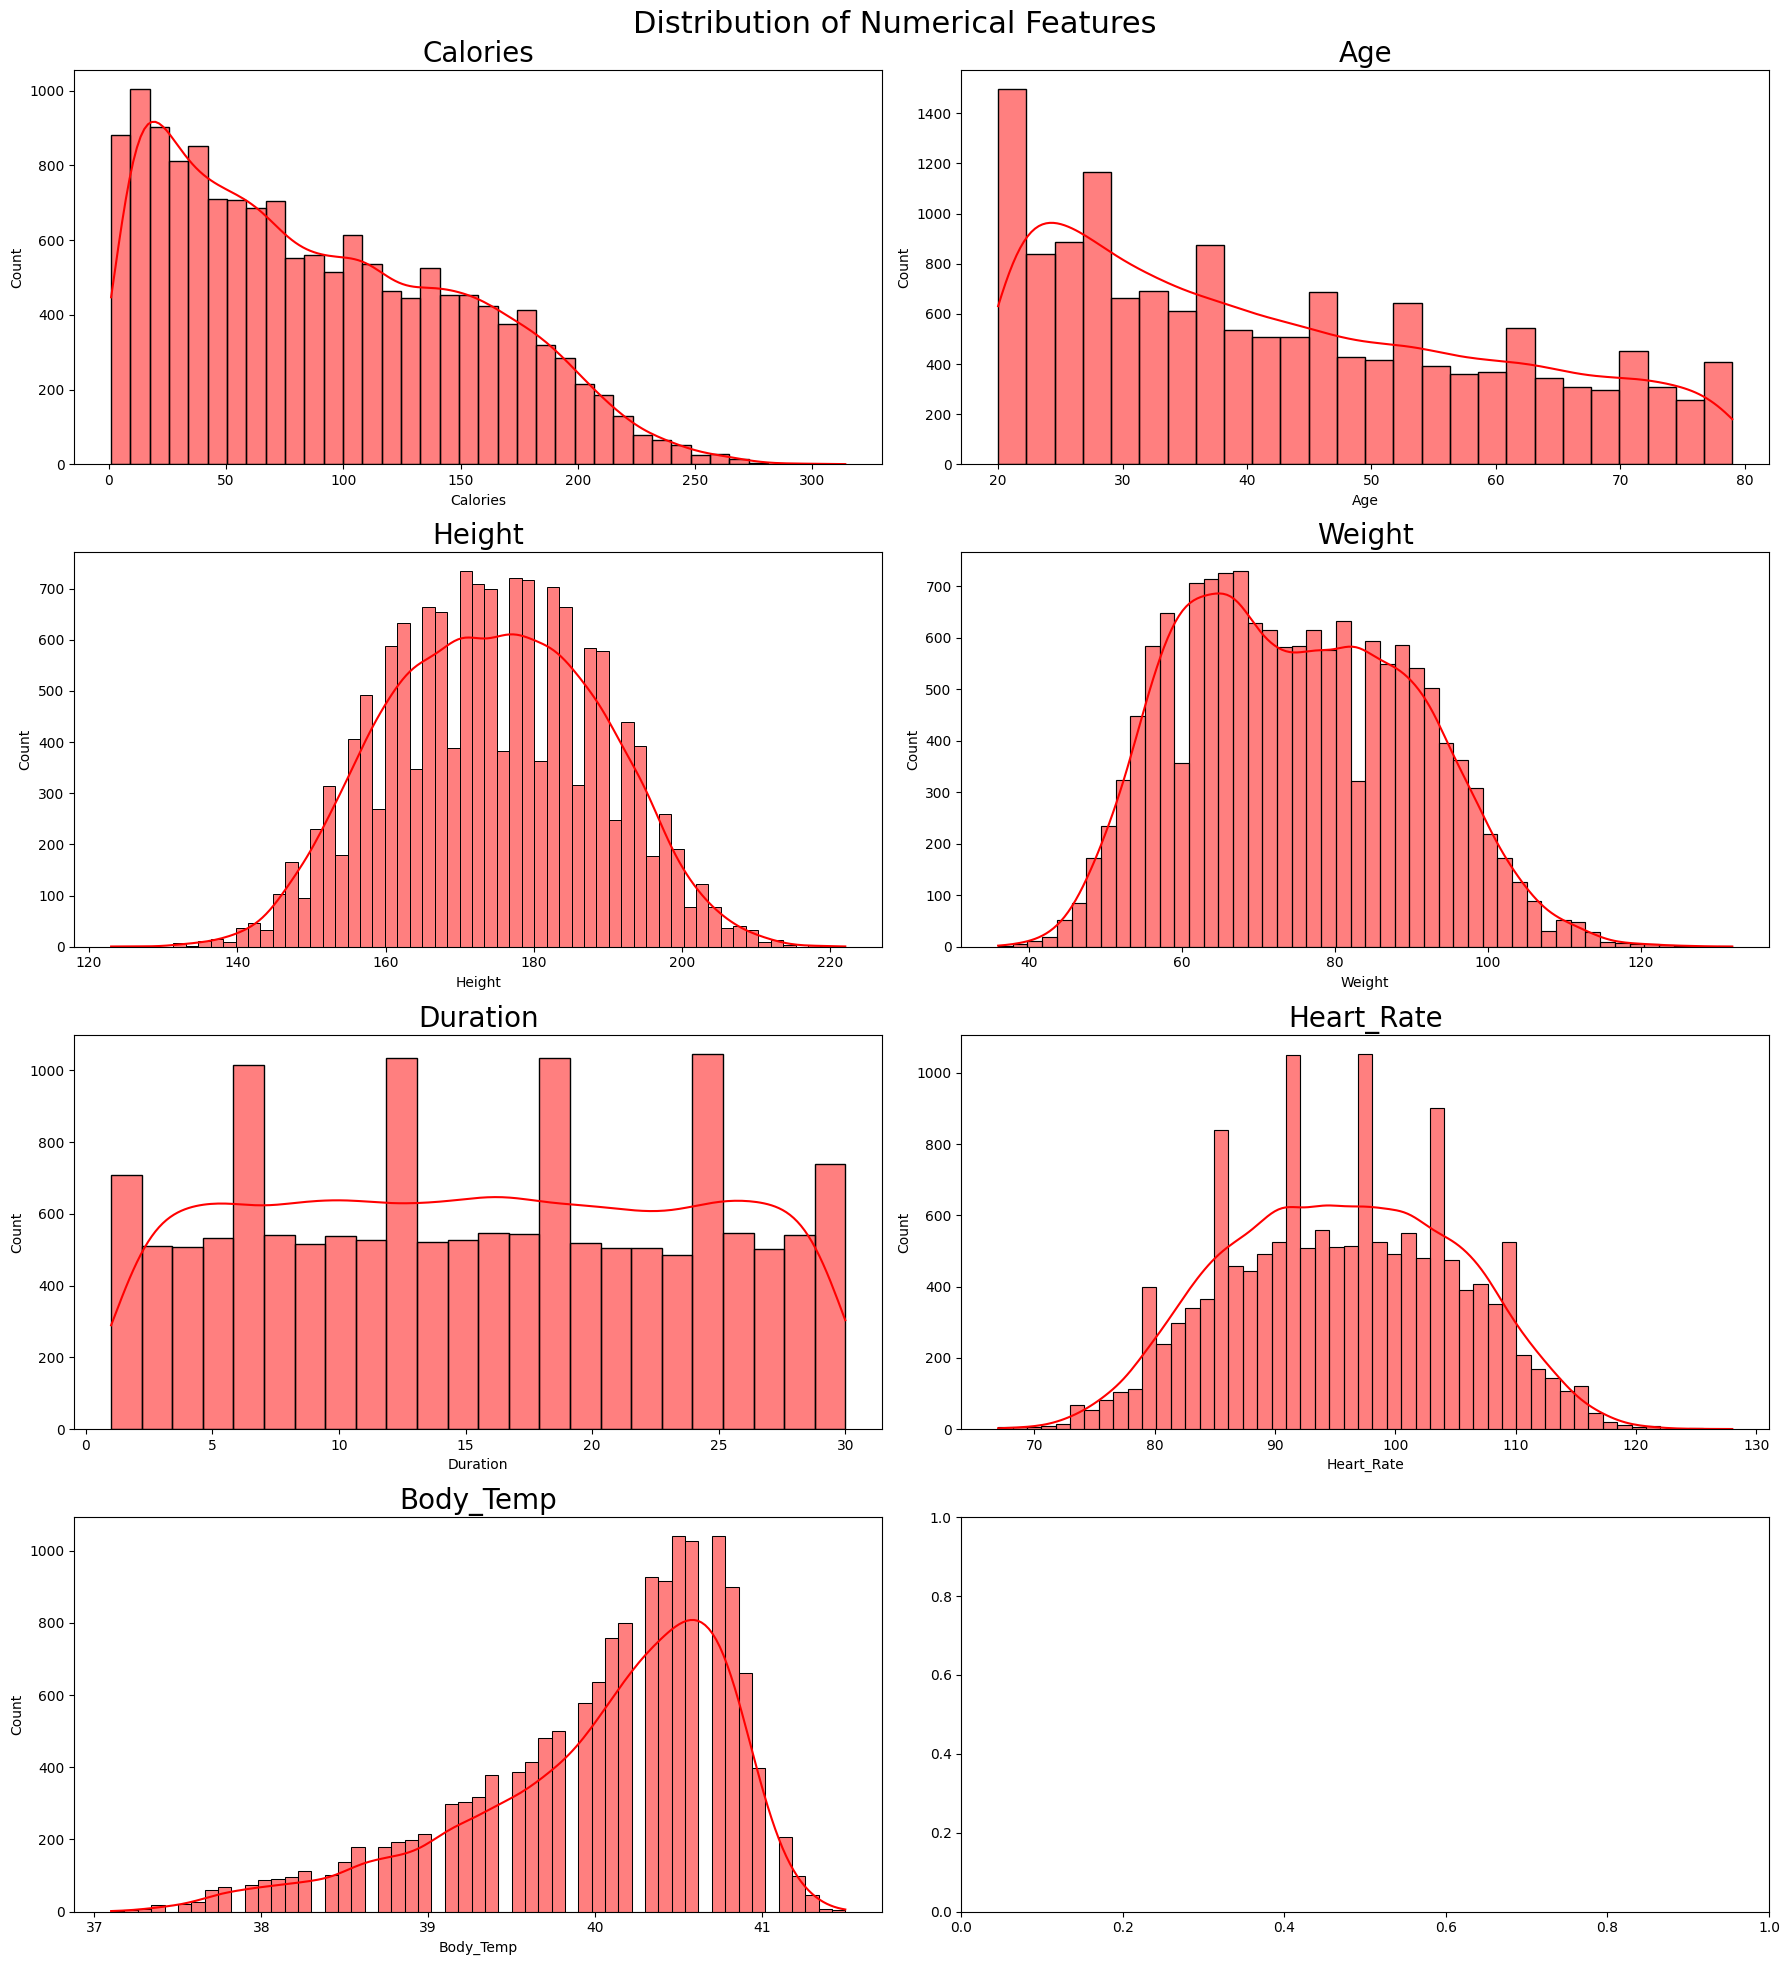

In [ ]:
# Set up the subplot for a 3x2 layout
numerical_features = [col for col in final_data.columns if final_data[col].dtype != 'O']

#Calculate the number of rows and columns needed for the subplots
num_rows = int(np.ceil(len(numerical_features) / 2))  # Calculate rows dynamically
num_cols = 2

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 20))  # Adjust grid

# Loop to plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    row = i // num_cols  # Update row calculation
    col_idx = i % num_cols

    # Plot histogram with KDE
    sns.histplot(final_data[feature], kde=True, ax=ax[row, col_idx], color='red')

    ax[row, col_idx].set_title(f'{feature}', fontsize=20)

# Hide any unused subplots (if any)
# No need for this part as we calculated rows and cols dynamically

plt.suptitle('Distribution of Numerical Features', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
final_data.head(1)

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8


### Categorical Variables Univariate Analysis

In [ ]:
# Filter out categorical features for the univariate analysis
categorical_features = ["Gender"]
df_categorical = final_data[categorical_features]

IndexError: index 2 is out of bounds for axis 0 with size 2

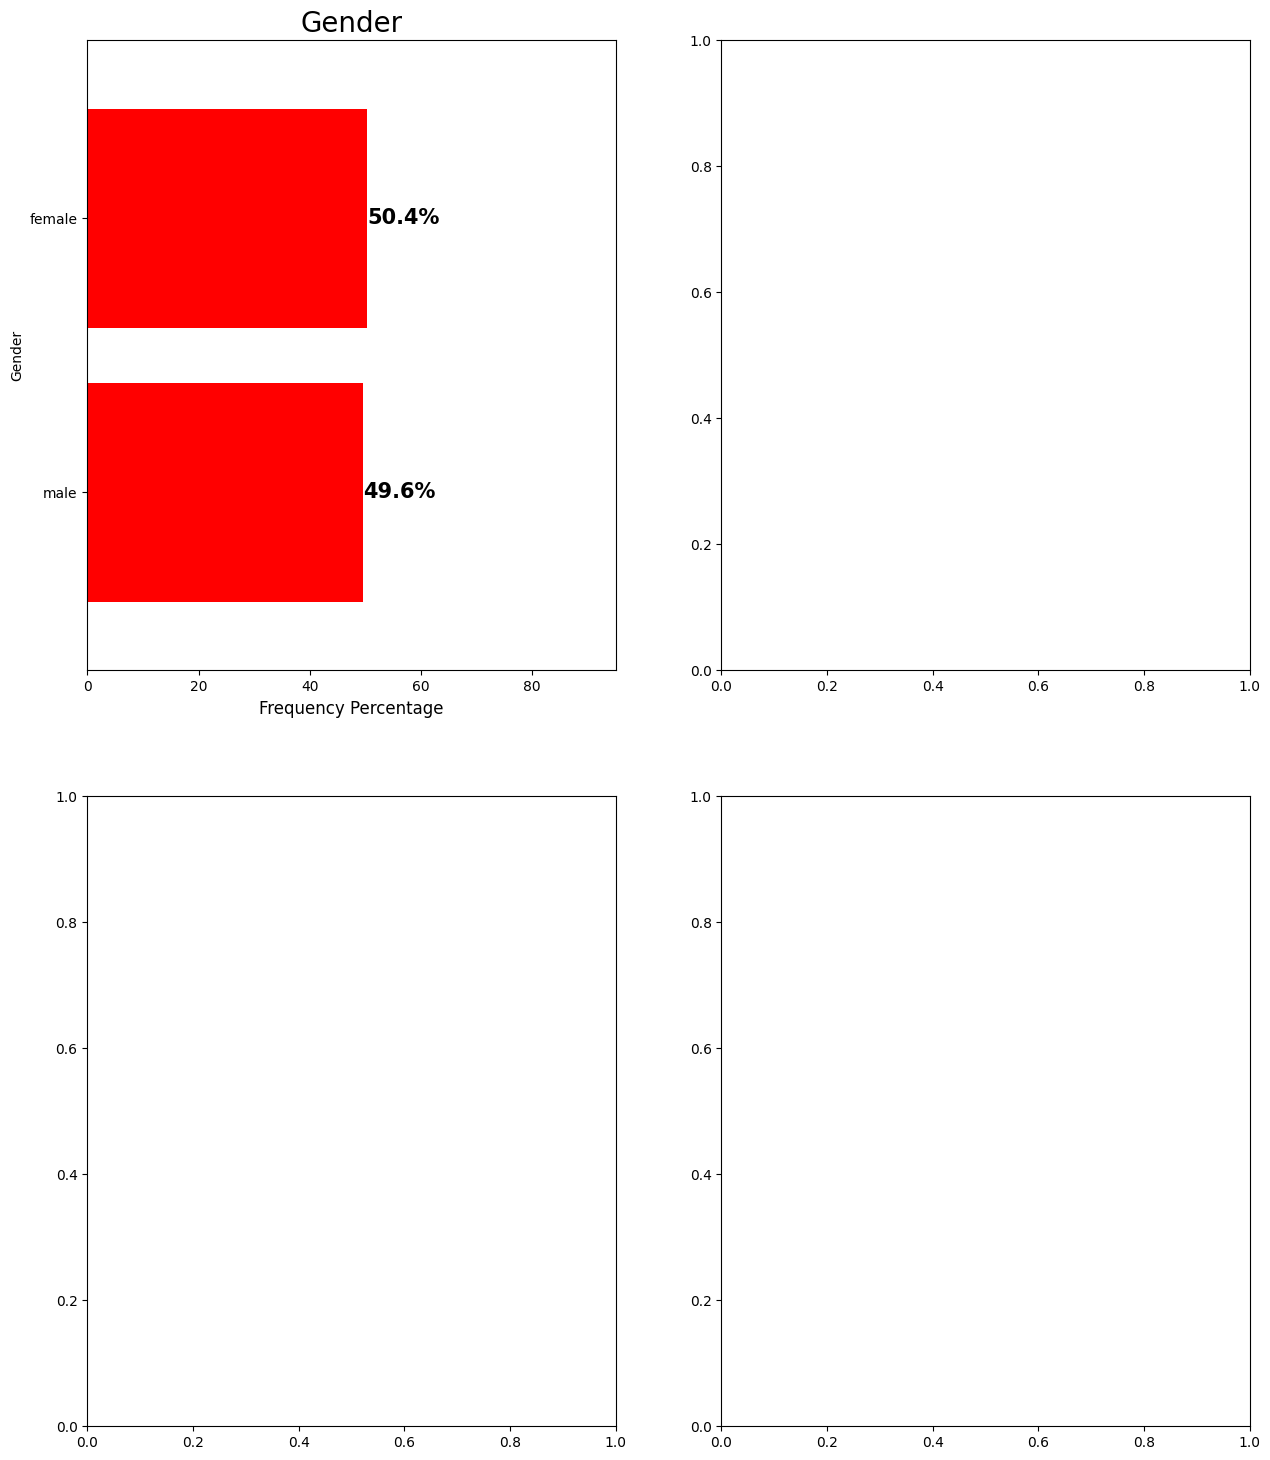

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2

    # Calculate frequency percentages
    value_counts = final_data[col].value_counts(normalize=True).mul(100).sort_values()

    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')

    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[2,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Bivariate Analysis

### Numerical Features vs Target

I am going to visualize each numerical feature against the target using two types of charts:

Boxplot and Hexbin Plot

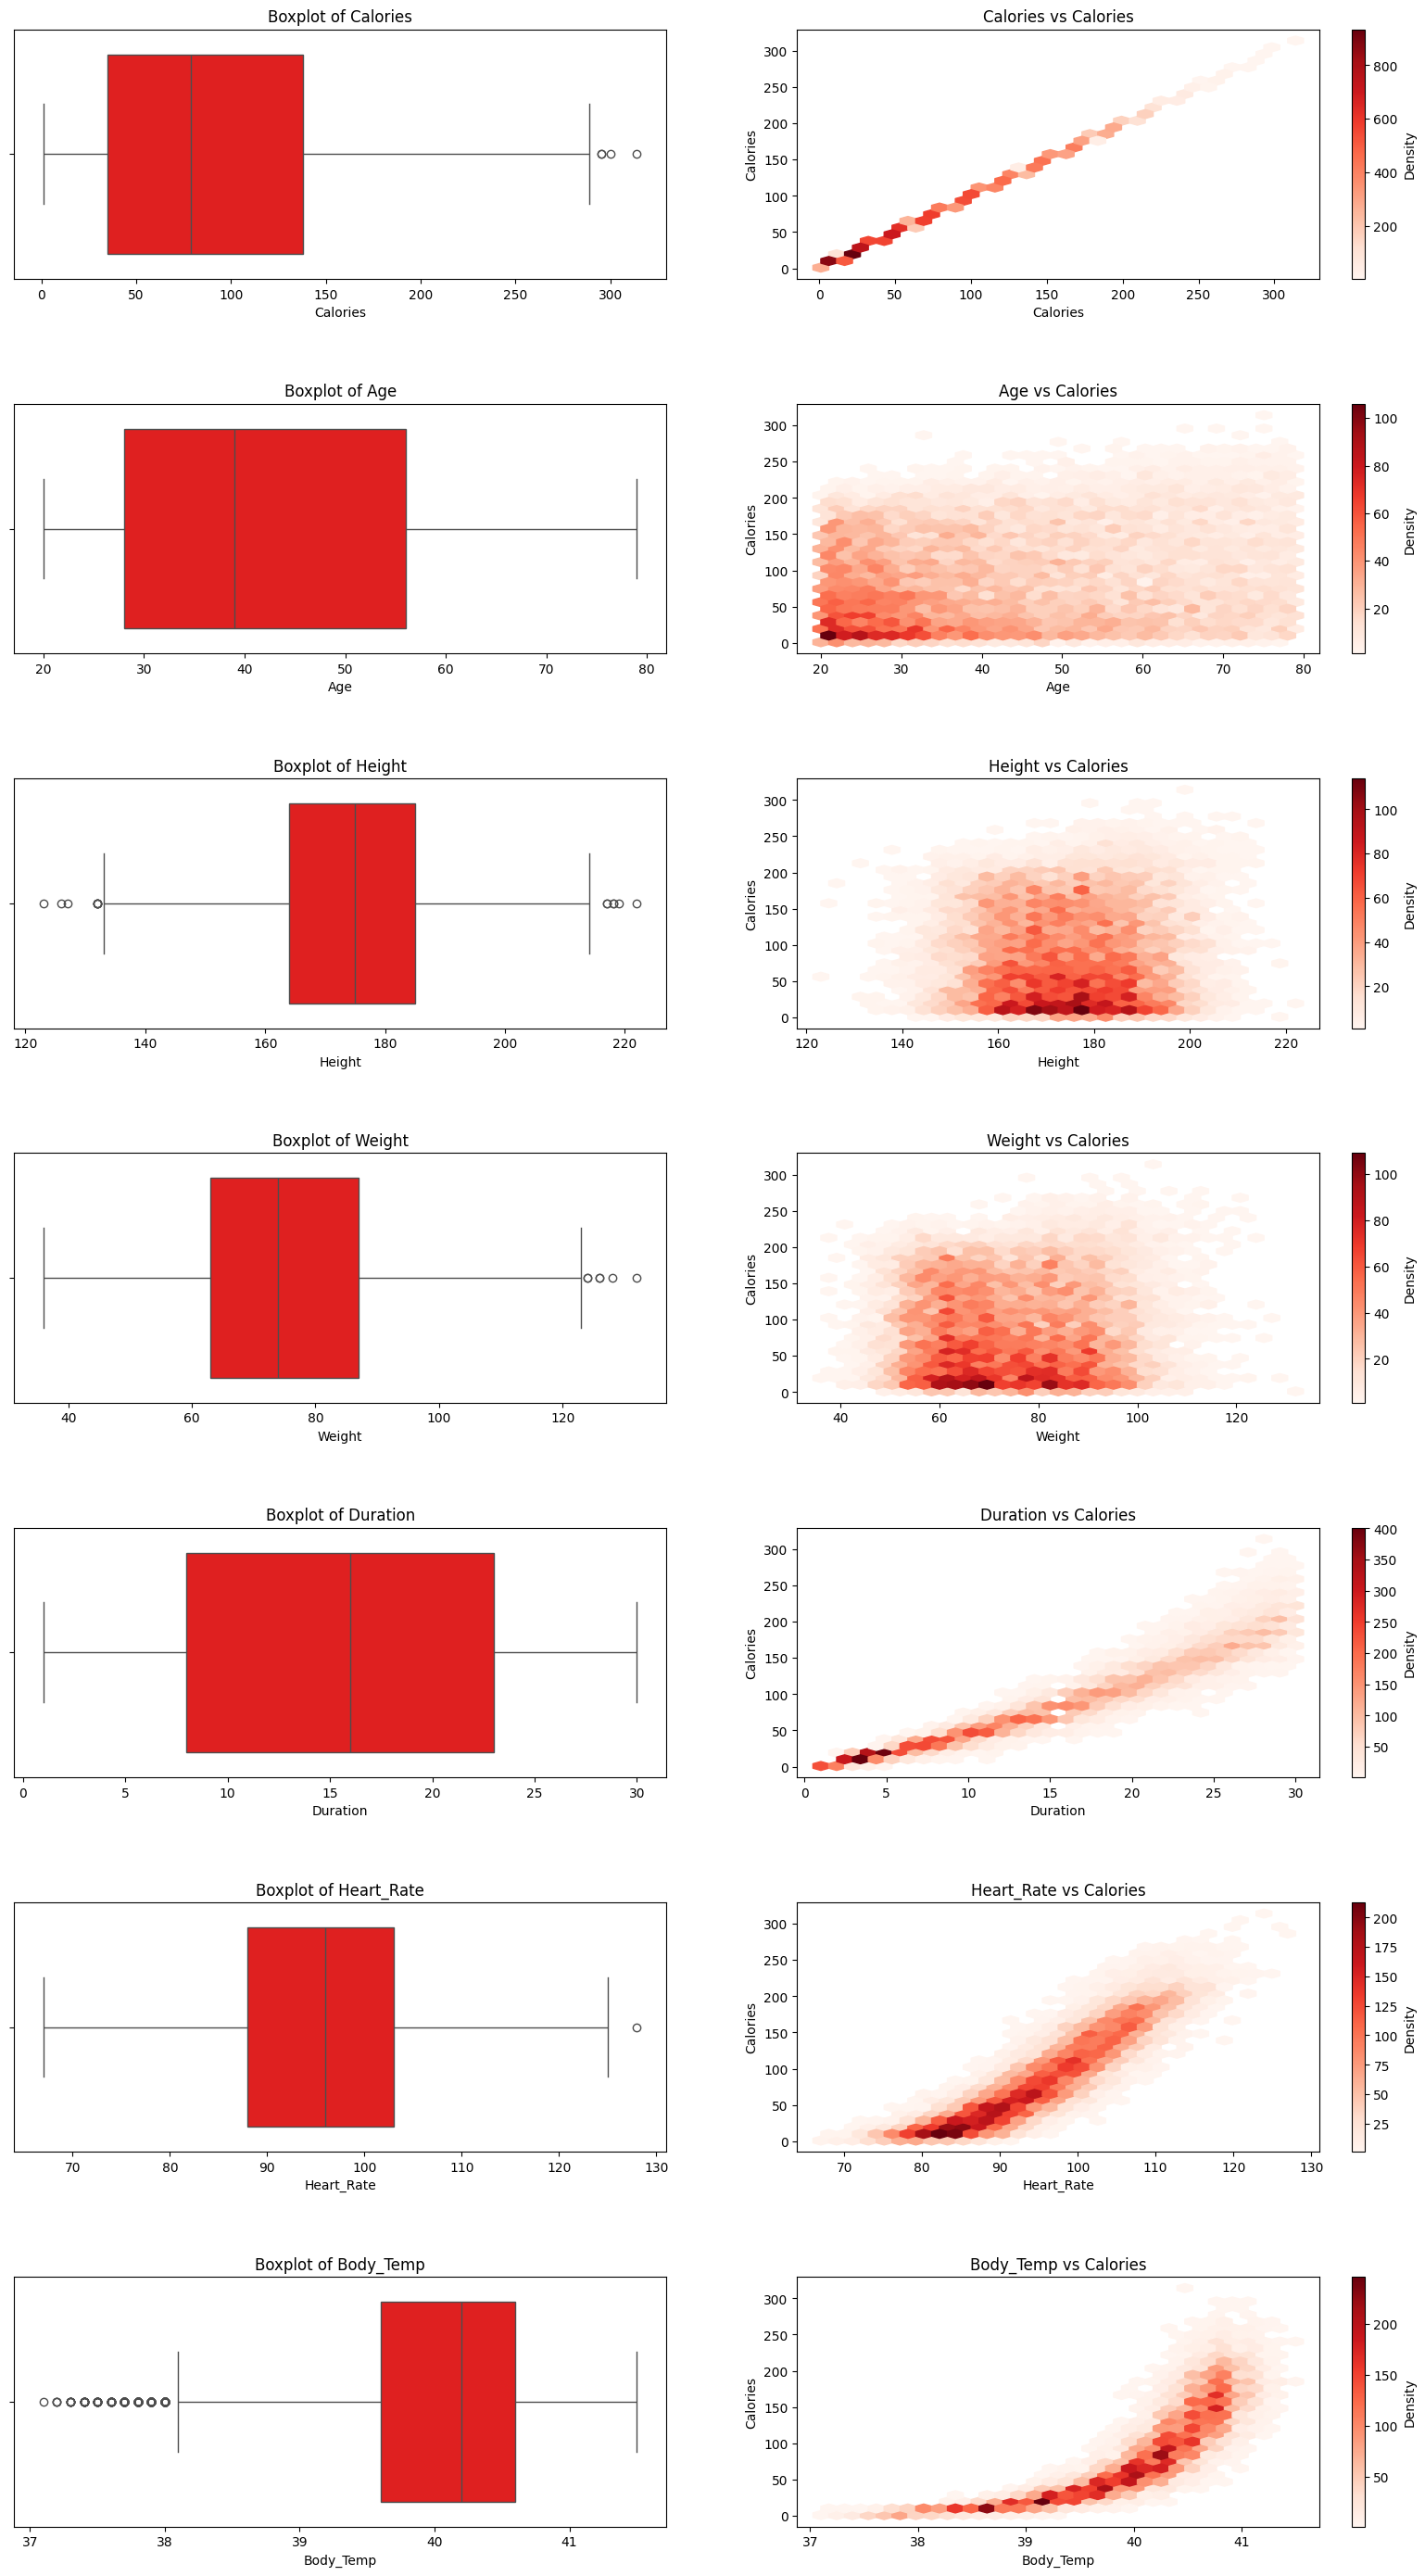

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(len(numerical_features), 2, figsize=(20, 35))
plt.subplots_adjust(hspace=0.5)

for i in range(len(numerical_features)):

    sns.boxplot(x=numerical_features[i], data=final_data, ax=ax[i, 0], color='red')
    ax[i, 0].set_title(f"Boxplot of {numerical_features[i]}")

    hb = ax[i, 1].hexbin(
        final_data[numerical_features[i]],
        final_data['Calories'],
        gridsize=30,
        cmap="Reds",
        mincnt=1
    )
    cb = fig.colorbar(hb, ax=ax[i, 1])
    cb.set_label("Density")
    ax[i, 1].set_title(f"{numerical_features[i]} vs Calories")
    ax[i, 1].set_xlabel(numerical_features[i])
    ax[i, 1].set_ylabel('Calories')


plt.show()

### Categorical Features vs ad_clicked Stacked Barplots

In [ ]:
final_data.head(1)

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8


I am going to check for outliers using the IQR method for the numerical features:

# Outliers

In [ ]:
# drop ad_clicked from numerical_features
numerical_features.remove('Calories')

Q1 = final_data[numerical_features].quantile(0.25)
Q3 = final_data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((final_data[numerical_features] < (Q1 - 1.5 * IQR)) | (final_data[numerical_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

,0
Age,0
Height,14
Weight,6
Duration,0
Heart_Rate,1
Body_Temp,369


Sensitivity to Outliers:

SVM (Support Vector Machine): SVMs can be sensitive to outliers. While the decision boundary is determined primarily by the support vectors, outliers can influence which data points are chosen as support vectors, potentially leading to suboptimal classification.
Decision Trees (DT) and Random Forests (RF): These tree-based algorithms are generally robust to outliers. They make splits based on feature values, and outliers often end up in leaf nodes, having minimal impact on the overall decision-making process.
K-Nearest Neighbors (KNN): KNN is sensitive to outliers because it relies on distances between data points to make predictions. Outliers can distort these distances.
AdaBoost: This ensemble method, which often uses decision trees as weak learners, is generally robust to outliers. However, the iterative nature of AdaBoost can sometimes lead to overemphasis on outliers, making the final model more sensitive to them.

In [ ]:
final_data.head()

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
# cheack dupicate
final_data.duplicated().sum()

np.int64(1)

In [ ]:
# drop duplicated
final_data.drop_duplicates(inplace=True)

In [ ]:
final_data.duplicated().sum()

np.int64(0)

In [ ]:
final_data.head(1)

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8


In [ ]:
final_data.head()

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
# copy final_data to df
df = final_data.copy()

In [ ]:
df.head()

,Calories,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,231.0,male,68,190.0,94.0,29.0,105.0,40.8
1,66.0,female,20,166.0,60.0,14.0,94.0,40.3
2,26.0,male,69,179.0,79.0,5.0,88.0,38.7
3,71.0,female,34,179.0,71.0,13.0,100.0,40.5
4,35.0,female,27,154.0,58.0,10.0,81.0,39.8


In [ ]:
df.shape

(14999, 8)

In [ ]:
# Calculation of the Spearman correlation
target = 'Calories'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(22,18), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2)
plt.show()

ValueError: could not convert string to float: 'male'

# --

# Train Test Split

First, it is essential to define the features (X) and the target labels (y) in the dataset. X is a DataFrame that holds the feature values for all observations, while y is a Series containing the categorical labels associated with each observation.

In [ ]:
X = df.drop('Calories', axis=1)
y = df['Calories']

In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# models

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(), ['Gender']),
    ('num', StandardScaler(), ['Age', 'Height', 'Weight', 'Duration','Heart_Rate', 'Body_Temp'])
], remainder='passthrough')

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())]
)

In [ ]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)


0.9987654091355109

In [ ]:
mean_absolute_error(y_test, y_pred)


1.5143567970395089

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(pipeline, X, y, cv = kfold, scoring = 'r2')

In [ ]:
cv_results.mean()

np.float64(0.9988346198157814)

In [ ]:
with open('pipeline_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)